## Repressilator

In [4]:
import os,glob
try:
    ## if using the Python 3 version
    from pycotools3 import viz, model, misc, tasks, models
except ImportError:
    ## fall back on the python 2 version 
    from pycotools import viz, model, misc, tasks, models
%matplotlib inline
import seaborn
seaborn.set_context('notebook')
seaborn.set_style('white')

### Define the Model

In [2]:
wd = r'D:\pycotools3\docs\source\Examples'

if not os.path.isdir(working_directory):
    os.makedirs(working_directory)

copasi_file = os.path.join(working_directory, 'repressilator.cps')

with model.BuildAntimony(copasi_file) as loader:
    mod = loader.load(
        """
        model Elowitz2000Repressilator()

          // Compartments and Species:
          compartment cell;
          species LacIProtein in cell, TetRProtein in cell, cIProtein in cell, LacImRNA in cell, TetRmRNA in cell, cImRNA in cell;

          // Assignment Rules:
          beta := mRNAHalfLife/ProteinHalfLife;
          alpha0 := a0_tr*TranslationEfficiency*ProteinHalfLife/(ln(2)*KM);
          a0_tr := tps_repr*60;
          alpha := a_tr*TranslationEfficiency*ProteinHalfLife/(ln(2)*KM);
          a_tr := (tps_active - tps_repr)*60;
          AveragemRNALifeTime := mRNAHalfLife/ln(2);
          kd_mRNA := ln(2)/mRNAHalfLife;
          kd_prot := ln(2)/ProteinHalfLife;
          k_tl := TranslationEfficiency/AveragemRNALifeTime;

          // Reactions:
          DegredationOfLacITranscripts: LacImRNA => ; cell*kd_mRNA*LacImRNA;
          DegredationOfTotRTranscripts: TetRmRNA => ; cell*kd_mRNA*TetRmRNA;
          DegredationOfCITranscripts: cImRNA => ; cell*kd_mRNA*cImRNA;
          TranslationOfLacI:  => LacIProtein; cell*k_tl*LacImRNA;
          TranslationOfTetR:  => TetRProtein; cell*k_tl*TetRmRNA;
          TranslationOfCI:  => cIProtein; cell*k_tl*cImRNA;
          DegradationOfLacI: LacIProtein => ; cell*kd_prot*LacIProtein;
          DegradationOfTetR: TetRProtein => ; cell*kd_prot*TetRProtein;
          DegradationOfCI: cIProtein => ; cell*kd_prot*cIProtein; 
          TranscriptionOfLacI:  => LacImRNA; cell*(a0_tr + a_tr*KM^n/(KM^n + cIProtein^n));
          TranscriptionOfTetR:  => TetRmRNA; cell*(a0_tr + a_tr*KM^n/(KM^n + LacIProtein^n));
          TranscriptionOfCI:  => cImRNA;     cell*(a0_tr + a_tr*KM^n/(KM^n + TetRProtein^n));

          // Species initializations:
          LacIProtein = 0;
          TetRProtein = 0;
          cIProtein = 0;
          LacImRNA = 0;
          TetRmRNA = 20;
          cImRNA = 0;

          // Compartment initializations:
          cell = 1;

          // Variable initializations:
          mRNAHalfLife = 2;
          ProteinHalfLife = 10;
          TranslationEfficiency = 20;
          KM = 40;
          n = 2;
          tps_active = 0.5;
          tps_repr = 0.0005;

          // Other declarations:
          var beta, alpha0, a0_tr, alpha, a_tr, AveragemRNALifeTime, kd_mRNA, kd_prot, k_tl;
          const cell, mRNAHalfLife, ProteinHalfLife, TranslationEfficiency, KM, n, tps_active, tps_repr;

          // Unit definitions:
          unit volume = 1e-15 litre;
          unit time_unit = 60 second;
          unit substance = item;
        end
        """
    )


### Simulate

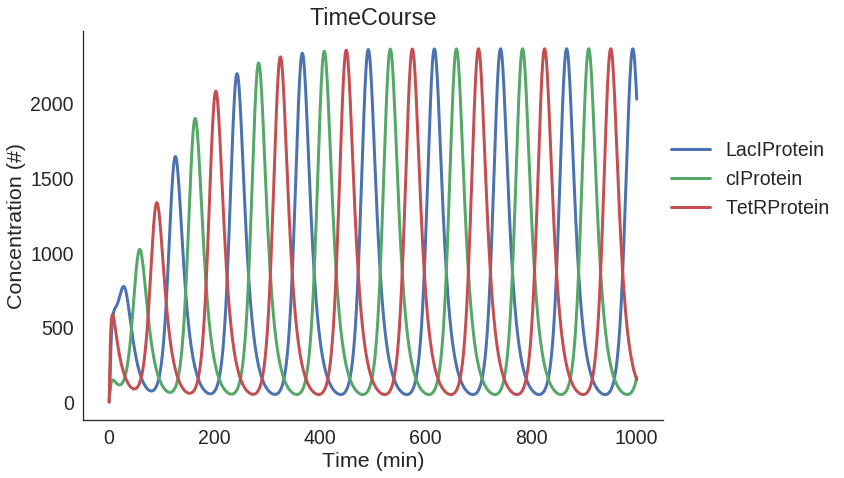

In [3]:
TC = tasks.TimeCourse(mod, end=1000, intervals=1000, step_size=1)
ax = viz.PlotTimeCourse(TC, separate=False, y=['LacIProtein', 'cIProtein', 'TetRProtein'],
                       legend_loc=(1, 0.5))